# U-NET Model Training

In [8]:
import neptune
import torch
import random
import imp

from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import u_net
import utils
#import env # env.py (file with API key included in .gitignore)
from dotenv import load_dotenv
import os
imp.reload(utils)

<module 'utils' from 'c:\\Users\\const\\Documents\\GitHub\\8DM20-Capita-Selecta\\MachineLearning\\code\\utils.py'>

In [2]:
# to ensure reproducible training/validation split
random.seed(42)

# find out if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# directorys with data and to store training checkpoints and logs
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights"

In [3]:
# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32
N_EPOCHS = 100
LEARNING_RATE = 1e-4
TOLERANCE = 0.01  # for early stopping

# find patient folders in training directory
# excluding hidden folders (start with .)
patient_paths = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("p") for part in path.parts)
]
random.shuffle(patient_paths)
cvae_paths = [
    path
    for path in DATA_DIR.glob("*")
    if path.parts[-1].startswith("c")
]

# split in training/validation after shuffling
partition = {
    "train": patient_paths[:-NO_VALIDATION_PATIENTS],
    "validation": patient_paths[-NO_VALIDATION_PATIENTS:],
}

# load training data and create DataLoader with batching and shuffling
dataset = utils.CombinedProstateMRDataset(partition["train"], cvae_paths, IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_dataset = utils.CombinedProstateMRDataset(partition["validation"], [], IMAGE_SIZE, valid=True)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# initialise model, optimiser, and loss function
loss_function = utils.DiceBCELoss()
unet_model = u_net.UNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)
minimum_valid_loss = 10  # initial validation loss

c:\Users\const\Documents\GitHub\8DM20-Capita-Selecta\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\const\Documents\GitHub\8DM20-Capita-Selecta\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\const\Documents\GitHub\8DM20-Capita-Selecta\.venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\const\Documents\GitHub\8DM20-Capita-Selecta\.venv\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\const\Documents\GitHub\8DM20-Capita-Selecta\.venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret =

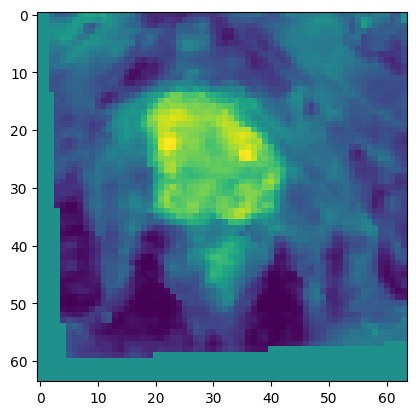

In [20]:
image, label = next(iter(dataloader))
plt.imshow(image.squeeze()[10])

In [22]:
# Initialize Neptune experiment
load_dotenv()
run = neptune.init_run(
    project="Capita-Selecta-Group-8/unet-cvae-data",
    api_token=os.getenv("NEPTUNE_KEY"),
    description="Verbetering dataloader",
    name="Run with correct dataloader"
)

# Track hyperparameters
run["parameters"] = {
    "lr": LEARNING_RATE,
    "bs": BATCH_SIZE,
    "epochs": N_EPOCHS,
    "input_sz": IMAGE_SIZE[0] * IMAGE_SIZE[1],
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# training loop
for epoch in range(N_EPOCHS):
    current_train_loss = 0.0
    current_valid_loss = 0.0

    for inputs, labels in tqdm(dataloader, position=0):
        # needed to zero gradients in each iterations
        optimizer.zero_grad()
        outputs = unet_model(inputs.to(device))  # forward pass
        loss = loss_function(outputs, labels.to(device).float())
        loss.backward()  # backpropagate loss
        current_train_loss += loss.item()
        optimizer.step()  # update weights

    # evaluate validation loss
    with torch.no_grad():
        unet_model.eval()
        for inputs, labels in tqdm(valid_dataloader, position=0):
            outputs = unet_model(inputs.to(device))  # forward pass
            loss = loss_function(outputs, labels.to(device).float())
            current_valid_loss += loss.item()

        unet_model.train()

    # Write to neptune log
    run["train/loss"].append(current_train_loss)
    run["valid/loss"].append(current_valid_loss)

    # if validation loss is improving, save model checkpoint
    # only start saving after 10 epochs
    if (current_valid_loss / len(valid_dataloader)) < minimum_valid_loss + TOLERANCE:
        minimum_valid_loss = current_valid_loss / len(valid_dataloader)
        weights_dict = {k: v.cpu() for k, v in unet_model.state_dict().items()}
        if epoch > 9:
            torch.save(
                weights_dict,
                CHECKPOINTS_DIR / f"u_net.pth",
            )

# End neptune run
run.stop()

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Capita-Selecta-Group-8/unet-cvae-data/e/UN-5


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torch.device'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.


[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/Capita-Selecta-Group-8/unet-cvae-data/e/UN-5/metadata
